## Generador De Música

Juan F. Castaño D. - Juan C. Misas T.

In [3]:
import os
from music21 import *
from collections import Counter
import subprocess
from IPython.display import Image, Audio, display
from pydub import AudioSegment
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

## Cargando los datos

In [4]:
archivo = "./beeth/"
midis = []

for i in os.listdir(archivo):
    if i.endswith(".mid"):
        tr = archivo + i
        midi = converter.parse(tr)
        midis.append(midi)

**Extracción de Notas y Acordes de Composiciones MIDI**

Para que nuestro modelo LSTM pueda aprender patrones musicales significativos, primero necesitamos extraer las notas y acordes de las composiciones de Beethoven. 

En este paso, usaremos la librería music21 para procesar archivos MIDI, que contienen las composiciones clásicas en formato digital. MIDI es un estándar en la industria musical que representa la información musical (notas, duración, instrumentos, etc.) de forma codificada.

**Objetivo:**

La función extraer_notas tiene como objetivo procesar cada composición en formato MIDI y extraer las notas y acordes presentes. Al final, tendremos una lista de todas las notas y acordes en forma textual, que servirá de base para entrenar nuestro modelo LSTM.

In [5]:

def extraer_notas(composicion):
    notas = []
    elegir = None
    for j in composicion:
        canciones = instrument.partitionByInstrument(j)
        for parte in canciones.parts:
            elegir = parte.recurse()
            for eleccion in elegir:
                if isinstance(eleccion, note.Note):
                    notas.append(str(eleccion.pitch))
                elif isinstance(eleccion, chord.Chord):
                    notas.append('.'.join(str(n) for n in eleccion.normalOrder))

    return notas

notas = extraer_notas(midis)

## Exploración de los datos

Función mostrar_partitura

Esta función toma una pieza musical, la convierte en un archivo MusicXML y luego usa MuseScore para convertirla en una imagen en formato PNG. Esto es útil para visualizar la música de forma gráfica, lo que permite tener una representación visual de las notas y acordes generados.


Función join_to_print

Esta función toma una secuencia de notas y acordes en formato textual (como los generados por la función extraer_notas) y los convierte en objetos de music21 (como Note y Chord). Luego, devuelve un objeto Stream que representa la partitura musical.

Estas dos funciones combinadas permiten procesar secuencias de notas/acordes, crear partituras y visualizar las composiciones generadas.

In [6]:
musescore_path = r'C:\Program Files\MuseScore 4\bin\MuseScore4.exe'  
if not os.path.exists(musescore_path):
    raise FileNotFoundError(f"MuseScore executable not found at {musescore_path}")
environment.set('musicxmlPath', musescore_path)

def mostrar_partitura(music):
    # Escribir la música en un archivo MusicXML
    musicxml_path = music.write('musicxml')
    
    # Convertir el archivo MusicXML a PNG usando MuseScore
    musicxml_path_str = str(musicxml_path)  # Convertir Path a string
    png_path = musicxml_path_str.replace('.musicxml', '.png')
    png_path_with_suffix = png_path.replace('.png', '-1.png')
    
    # Ejecutar el comando de MuseScore y capturar la salida
    command = f'"{musescore_path}" -o "{png_path}" "{musicxml_path_str}"'
    print(f"Executing command: {command}")
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    print(f"Command stdout: {result.stdout}")
    print(f"Command stderr: {result.stderr}")
    
    # Verificar si se creó el archivo PNG con o sin el sufijo -1
    if not os.path.exists(png_path):
        if os.path.exists(png_path_with_suffix):
            png_path = png_path_with_suffix
        else:
            raise FileNotFoundError(f"PNG file not created: {png_path} or {png_path_with_suffix}")
    
    # Mostrar la imagen PNG
    display(Image(png_path))

def join_to_print(fragmento):
    obra = []
    offset = 0
    
    for x in fragmento:
        if ('.' in x or x.isdigit()):  # si es un acorde, inicia con un número o con un punto '.'
            notas_del_acorde = x.split('.')  # se separan las notas del acorde
            notas = []

            for y in notas_del_acorde:
                nota_int = int(y)
                nota_frag = note.Note(nota_int)  # se convierte el fragmento de int a Note
                notas.append(nota_frag)
            acorde_frag = chord.Chord(notas)
            acorde_frag.offset = offset
            obra.append(acorde_frag)
        else:
            nota_frag = note.Note(x)
            nota_frag.offset = offset
            obra.append(nota_frag)
        
        offset += 1
    
    obra_midi = stream.Stream(obra)
    return obra_midi

fragmento_obra funciona para generar un fragmento de una partitura basada en las primeras 100 notas de la secuencia notas y luego mostrar la partitura visualmente.

Executing command: "C:\Program Files\MuseScore 4\bin\MuseScore4.exe" -o "C:\Users\jcast\AppData\Local\Temp\music21\tmpo1x0d5f3.png" "C:\Users\jcast\AppData\Local\Temp\music21\tmpo1x0d5f3.musicxml"
Command stdout: 
Command stderr: 


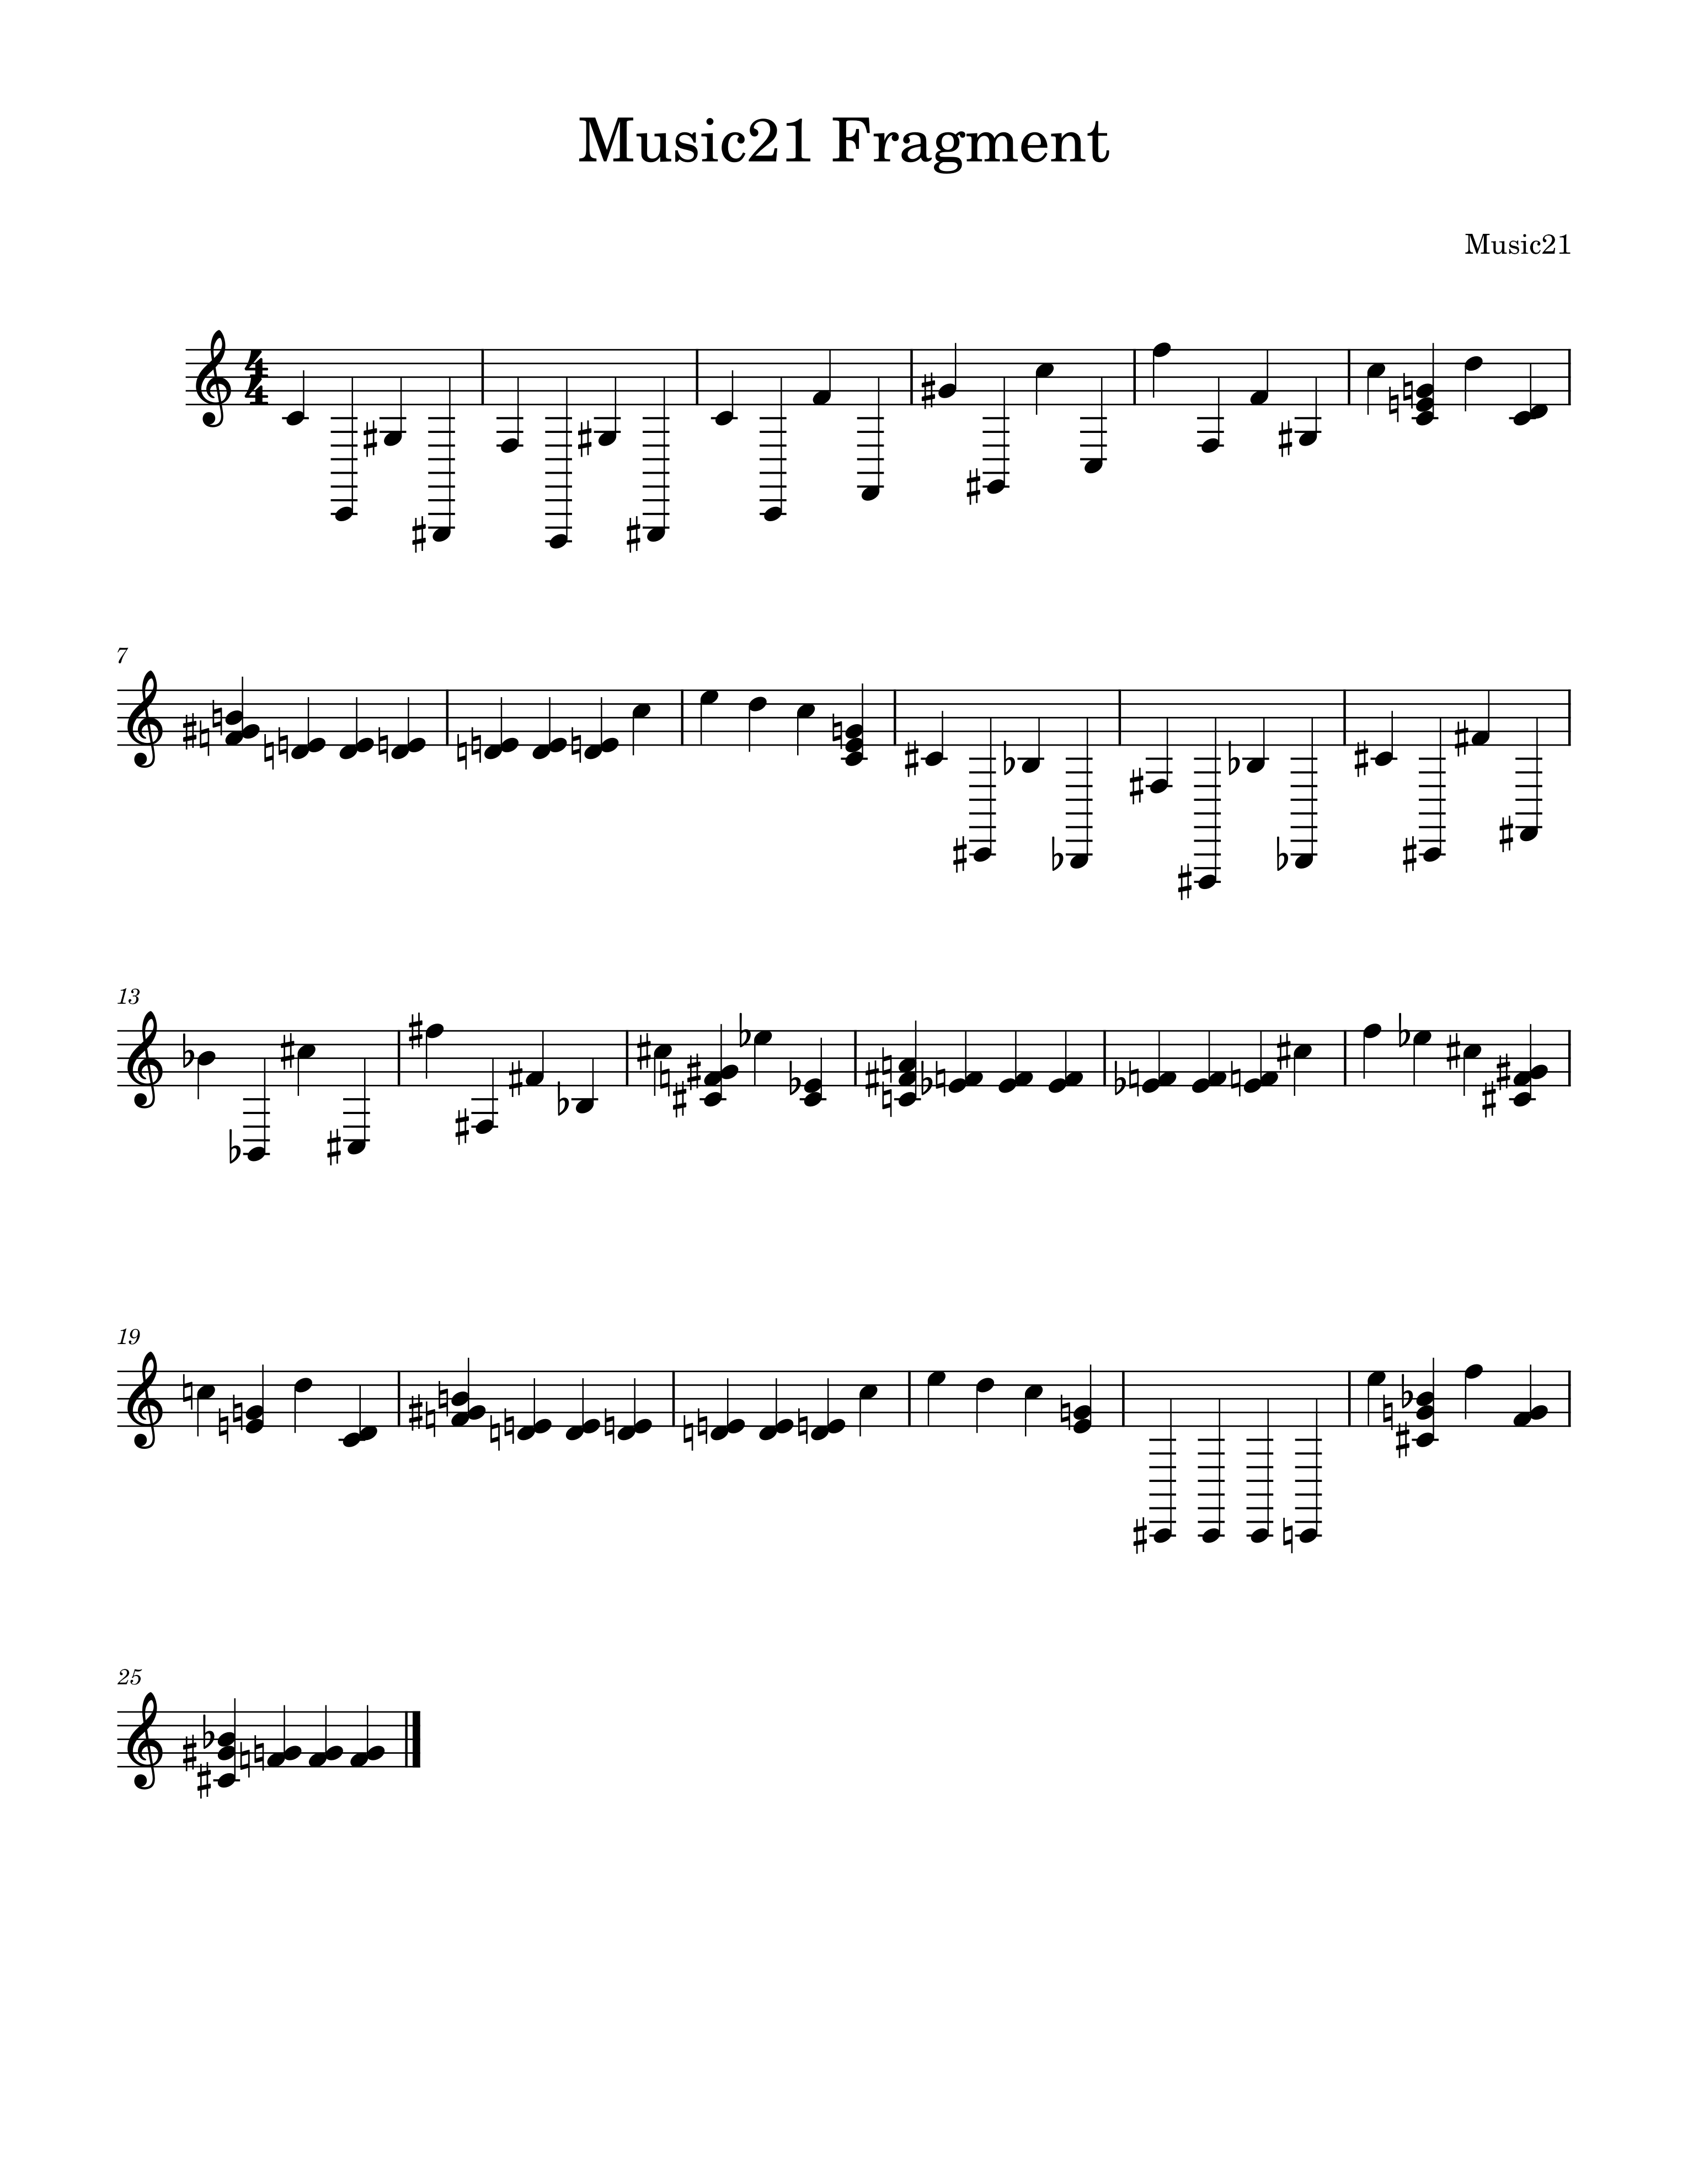

In [7]:
fragmento_obra = join_to_print(notas[:100]) # Notas es una lista de str
mostrar_partitura(fragmento_obra)

#### Reproducción del fragmento del conjunto de notas

In [8]:
fragmento_obra.show('midi')

##### Reproducción de una composición de Beethoven

In [46]:
midis[0].show('midi')

Counter devuelve un diccionario donde las claves son las notas o acordes, y los valores son el número de veces que aparece cada uno. De esta forma podemos determinar el número de acordes y notas únicas.

In [10]:
notas_unicas = Counter(notas)
print("Número de notas únicas:", len(notas_unicas))
notas_unicas

Número de notas únicas: 349


Counter({'C4': 2094,
         'G3': 1881,
         'C5': 1813,
         'E-4': 1620,
         'G4': 1615,
         'B-3': 1596,
         'F4': 1586,
         'G#3': 1577,
         'E-3': 1536,
         'F3': 1486,
         'E-5': 1456,
         'F5': 1416,
         'B3': 1384,
         'B-4': 1364,
         'C3': 1337,
         'G#4': 1263,
         'G5': 1249,
         'D4': 1232,
         'D5': 1222,
         'E4': 1186,
         'B4': 1182,
         'A3': 1110,
         'B-2': 1077,
         'A4': 1055,
         'G#5': 1046,
         'E3': 1036,
         'G#2': 1027,
         'C#5': 1024,
         'C#4': 1012,
         'C6': 991,
         'E5': 981,
         'D3': 975,
         'F#4': 961,
         'G2': 838,
         'B-5': 804,
         'F#3': 783,
         'C2': 747,
         'A5': 721,
         'B5': 718,
         'F2': 710,
         'C#3': 697,
         'F#5': 660,
         '5.8': 658,
         'B2': 650,
         '0': 618,
         'D6': 575,
         '7.10': 569,
         '0.

Este fragmento de código tiene como objetivo analizar las frecuencias de las notas y acordes en las composiciones de Beethoven, específicamente calculando:

Promedio de frecuencias: El promedio de cuántas veces aparece cada nota o acorde en la lista.

Nota más común: La frecuencia con la que aparece la nota o acorde más común en la secuencia.

Nota menos común: La frecuencia con la que aparece la nota o acorde menos común.

In [53]:
Notas = list(notas_unicas.keys())
Frecuencias = list(notas_unicas.values())

def promedio(lista):
    return sum(lista) / len(lista)

print("Promedio de frecuencias:", promedio(Frecuencias))
print(f"Nota más común: {max(Frecuencias)} veces") # C4
print(f"Nota menos común: {min(Frecuencias)} veces")


Promedio de frecuencias: 232.98853868194843
Nota más común: 2094 veces
Nota menos común: 1 veces


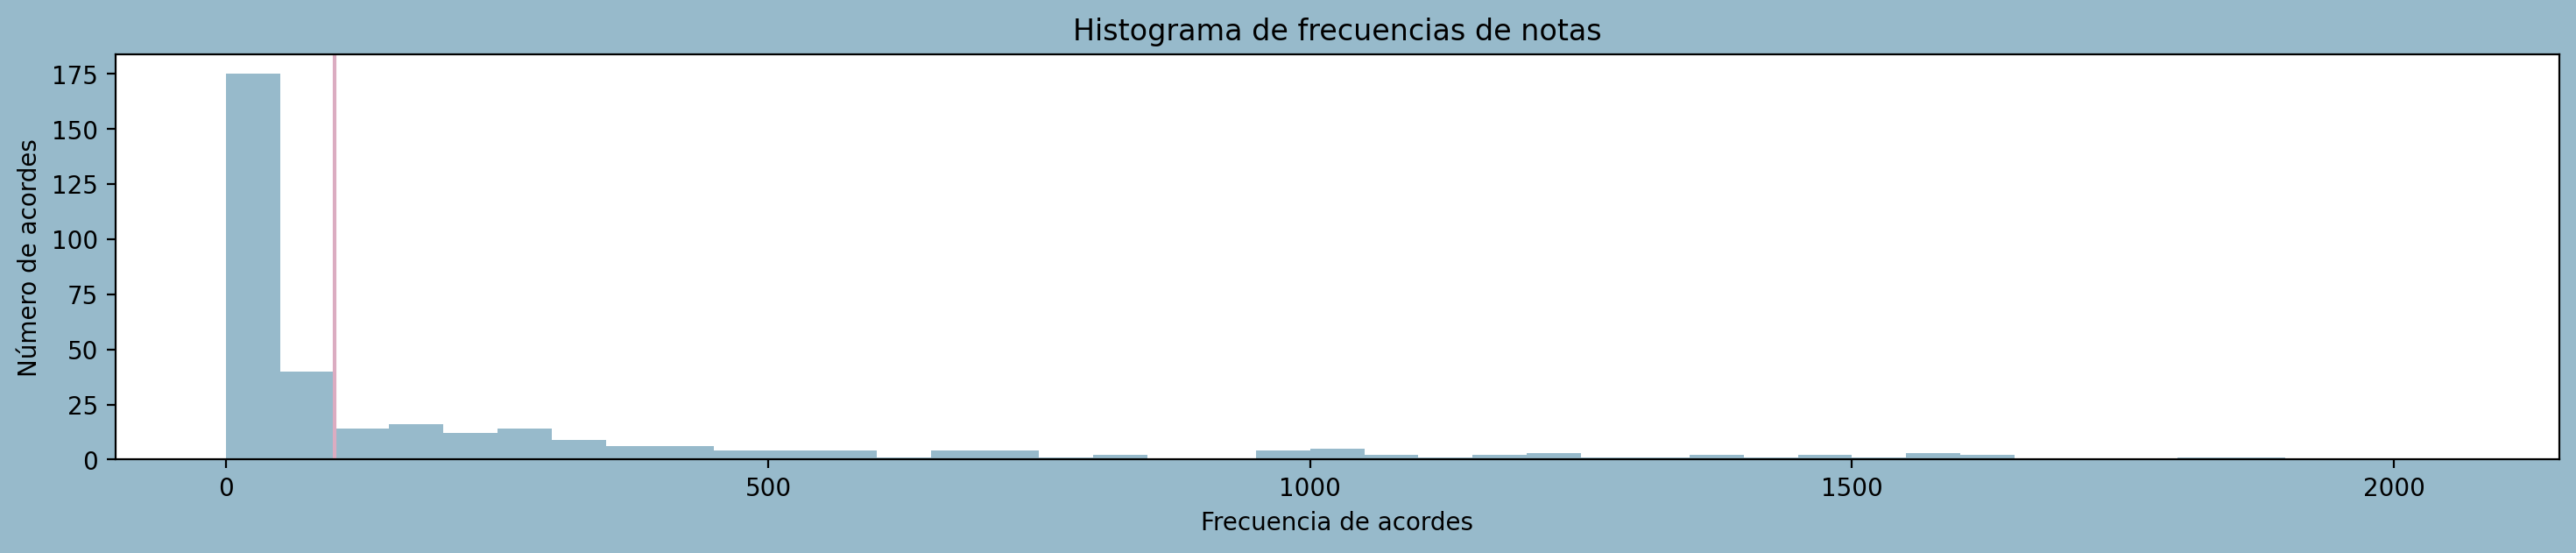

In [12]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0, max(Frecuencias), 50)
plt.hist(Frecuencias, bins=bins, color='#97BACB')
plt.axvline(x = 100, color = "#DBACC1")
plt.title("Histograma de frecuencias de notas")
plt.xlabel("Frecuencia de acordes")
plt.ylabel("Número de acordes")
plt.show()

En la siguiente celda, el objetivo es identificar las notas raras, es decir, aquellas notas o acordes que aparecen con una frecuencia menor a 100 (esto fijado por nosotros) en la secuencia extraída de las composiciones de Beethoven.

In [13]:
notas_raras = []

for i, (key, value) in enumerate(notas_unicas.items()):
    if value < 100:
        notas_raras.append(key)

print("Notas raras (Notas con frecuencia menor a 100):", len(notas_raras))
print("Notas raras:", notas_raras)

Notas raras (Notas con frecuencia menor a 100): 215
Notas raras: ['5.8.11', 'F#1', '6.9.0', '7.10.1', '8.10.1', 'B-6', '4.8.11', '3.6.9', '2.5.8', '1.4.7', '1.3.7', '10.1.3', '8.11.3', 'B6', '11.3.6', '11.1', '4.7.10', '9.1', '8.9', '6.9.1', 'C7', '10.1.5', '8.11.2', '6.8.0', '3.6.8', '1.3.6', '0.3.5', '3.6.10', '9.0.3', '8.11.1', '11.2.6', '5.11', '0.6', '1.4.7.10', '0.3.6', '11.2.5', '4.7.10.0', '7.10.0', '10.0.4', 'A6', '3.5.9', '1.5.7', '5.7.10', '1.3.8', '5.6.8', '5.6', '1.7', '1.3.6.8', '0.3.6.8', '5.8.10', '10.1.3.6', '10.0.3', '0.3.6.9', '5.7.11', '6.11', '2.5.8.11', '2.8', '2.7', '0.4.6', '10.2.3.5', '2.5.7.10', '3.5.10', '5.7.0', '2.5.9', '4.10', '10.0.2', '9.10.3', '10.1.4', '2.6.10', '7.10.0.3', '8.10.0.3', '9.10.0.3', '2.6.9', '6.9.0.2', 'D7', 'E7', '9.0.2', '4.7.11', '4.9', 'C#7', '4.7.9', '7.9.1', '0.2.5', '11.2.4', '9.0.4', '2.5.7', '3.7.11', '7.8.0.3', '7.10.2', '2.5.8.10', '2.4.7.10', '11.4', '1.4.6', '4.6', '4.5.10', '6.8.10', '5.6.10', '10.1.4.6', '5.8.11.1', '11.2.

Aquí eliminamos las notas raras de la lista original de notas.

In [14]:
for nota in notas:
    if nota in notas_raras:
        notas.remove(nota)

print("Número de notas después de eliminar notas raras:", len(notas))

Número de notas después de eliminar notas raras: 77571


## Preprocesamiento de los datos

Mapeamos con un diccionario cada nota única a un número natural (mapeo)
Creamos otro diccionario que hace el mapeo inverso, es decir, del número entero a la nota (mapeo inverso).

In [15]:
dic_notas_unicas = sorted(list(set(notas)))

len_notas = len(notas)
len_dic_notas_unicas = len(dic_notas_unicas)

mapeo = dict((nota, num) for num, nota in enumerate(dic_notas_unicas))
mapeo_inverso = dict((num, nota) for num, nota in enumerate(dic_notas_unicas))

print("Número de notas en el diccionario:", len_dic_notas_unicas)
print("Número de notas en la todas las composiciones:", len_notas)

mapeo

Número de notas en el diccionario: 248
Número de notas en la todas las composiciones: 77571


{'0': 0,
 '0.1': 1,
 '0.1.4': 2,
 '0.2': 3,
 '0.2.3': 4,
 '0.3': 5,
 '0.3.5': 6,
 '0.3.6': 7,
 '0.3.6.9': 8,
 '0.3.7': 9,
 '0.4': 10,
 '0.4.7': 11,
 '0.4.8': 12,
 '0.5': 13,
 '0.6': 14,
 '1': 15,
 '1.2': 16,
 '1.2.3': 17,
 '1.3': 18,
 '1.3.7': 19,
 '1.4': 20,
 '1.4.6': 21,
 '1.4.7': 22,
 '1.4.7.10': 23,
 '1.4.8': 24,
 '1.5': 25,
 '1.5.8': 26,
 '1.6': 27,
 '1.7': 28,
 '10': 29,
 '10.0': 30,
 '10.0.1.3': 31,
 '10.0.3': 32,
 '10.0.3.6': 33,
 '10.0.4': 34,
 '10.0.5': 35,
 '10.1': 36,
 '10.1.3': 37,
 '10.1.3.6': 38,
 '10.1.4': 39,
 '10.1.4.6': 40,
 '10.1.5': 41,
 '10.11': 42,
 '10.2': 43,
 '10.2.4': 44,
 '10.2.5': 45,
 '10.3': 46,
 '11': 47,
 '11.0': 48,
 '11.1': 49,
 '11.2': 50,
 '11.2.4': 51,
 '11.2.4.6': 52,
 '11.2.5': 53,
 '11.2.5.7': 54,
 '11.2.6': 55,
 '11.3': 56,
 '11.3.5': 57,
 '11.3.6': 58,
 '11.4': 59,
 '2': 60,
 '2.3': 61,
 '2.3.5': 62,
 '2.3.5.8.10': 63,
 '2.4': 64,
 '2.4.7.10': 65,
 '2.5': 66,
 '2.5.7': 67,
 '2.5.8': 68,
 '2.5.8.10': 69,
 '2.5.8.11': 70,
 '2.6': 71,
 '2.6.9': 7

Aquí, utilizamos un bucle para iterar a través de la lista de notas. Para cada posición x, extraemos una subsecuencia de 40 notas, que llamamos feature. La nota que sigue a esta subsecuencia se asigna a target, nuestra variable objetivo. Luego, convertimos ambas a sus representaciones numéricas utilizando el diccionario mapeo. Las características se almacenan en la lista features, mientras que las notas objetivo se añaden a la lista targets.

Finalmente, contamos cuántos datos hemos generado

In [16]:
size=40
features = []
targets = []

for x in range(0,len_notas-size,1):
    feature  = notas[x:x+size]
    target = notas[x+size]
    features.append([mapeo[y] for y in feature])
    targets.append(mapeo[target])

len_datapoints=len(targets)

Convertimos tanto las features y targets en tensores de PyTorch, (x,y respectivamente), "y" es de tipo long lo cual es apropiado para las etiquetas de clasificación; finalmente normalizamos X.

In [17]:
X = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(targets, dtype=torch.long) #torch.long

# Normalizar X
X = np.reshape(X,(len_datapoints,size,1)) / float(len(mapeo))

Hacemos la partición entre X_train, X_test, y_train, y_test (Proporición 80% Train, 20% Test)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Construcción del model

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(LSTMModel, self).__init__()
        self.lstm_1 = nn.LSTM(input_size, hidden_size_1, batch_first=True, dropout=0.1, num_layers=1)
        self.lstm_2 = nn.LSTM(hidden_size_1, hidden_size_2, batch_first=True, num_layers=1)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.fc_1 = nn.Linear(hidden_size_2, 256) 
        self.fc_2 = nn.Linear(256, output_size)
    
    def forward(self, x):
        x, (hn, cn) = self.lstm_1(x)
        x, (hn, cn) = self.lstm_2(x)
        x = self.dropout1(x[:, -1, :])
        x = self.fc_1(x)
        x = self.dropout2(x)
        x = self.fc_2(x)
        return x

In [29]:
input_size = X_train.shape[2] # 1
hidden_size_1 = 512
hidden_size_2 = 256
output_size = len(mapeo) # 248

model = LSTMModel(input_size, hidden_size_1, hidden_size_2, output_size)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01)

X_train.shape

torch.Size([62024, 40, 1])

CUDA is available. Using GPU.
Epoch 1/200, loss: 1.7189
Epoch 2/200, loss: 1.5523
Epoch 3/200, loss: 1.4898
Epoch 4/200, loss: 1.4537
Epoch 5/200, loss: 1.4441
Epoch 6/200, loss: 1.4203
Epoch 7/200, loss: 1.4095
Epoch 8/200, loss: 1.3980
Epoch 9/200, loss: 1.3637
Epoch 10/200, loss: 1.3538
Epoch 11/200, loss: 1.3338
Epoch 12/200, loss: 1.3110
Epoch 13/200, loss: 1.2981
Epoch 14/200, loss: 1.2862
Epoch 15/200, loss: 1.2691
Epoch 16/200, loss: 1.2429
Epoch 17/200, loss: 1.2261
Epoch 18/200, loss: 1.2129
Epoch 19/200, loss: 1.1935
Epoch 20/200, loss: 1.1771
Epoch 21/200, loss: 1.1628
Epoch 22/200, loss: 1.1563
Epoch 23/200, loss: 1.1341
Epoch 24/200, loss: 1.1187
Epoch 25/200, loss: 1.1053
Epoch 26/200, loss: 1.0811
Epoch 27/200, loss: 1.0669
Epoch 28/200, loss: 1.0615
Epoch 29/200, loss: 1.0534
Epoch 30/200, loss: 1.0345
Epoch 31/200, loss: 1.0644
Epoch 32/200, loss: 1.0539
Epoch 33/200, loss: 1.0545
Epoch 34/200, loss: 1.0387
Epoch 35/200, loss: 1.0495
Epoch 36/200, loss: 1.0449
Epoch 3

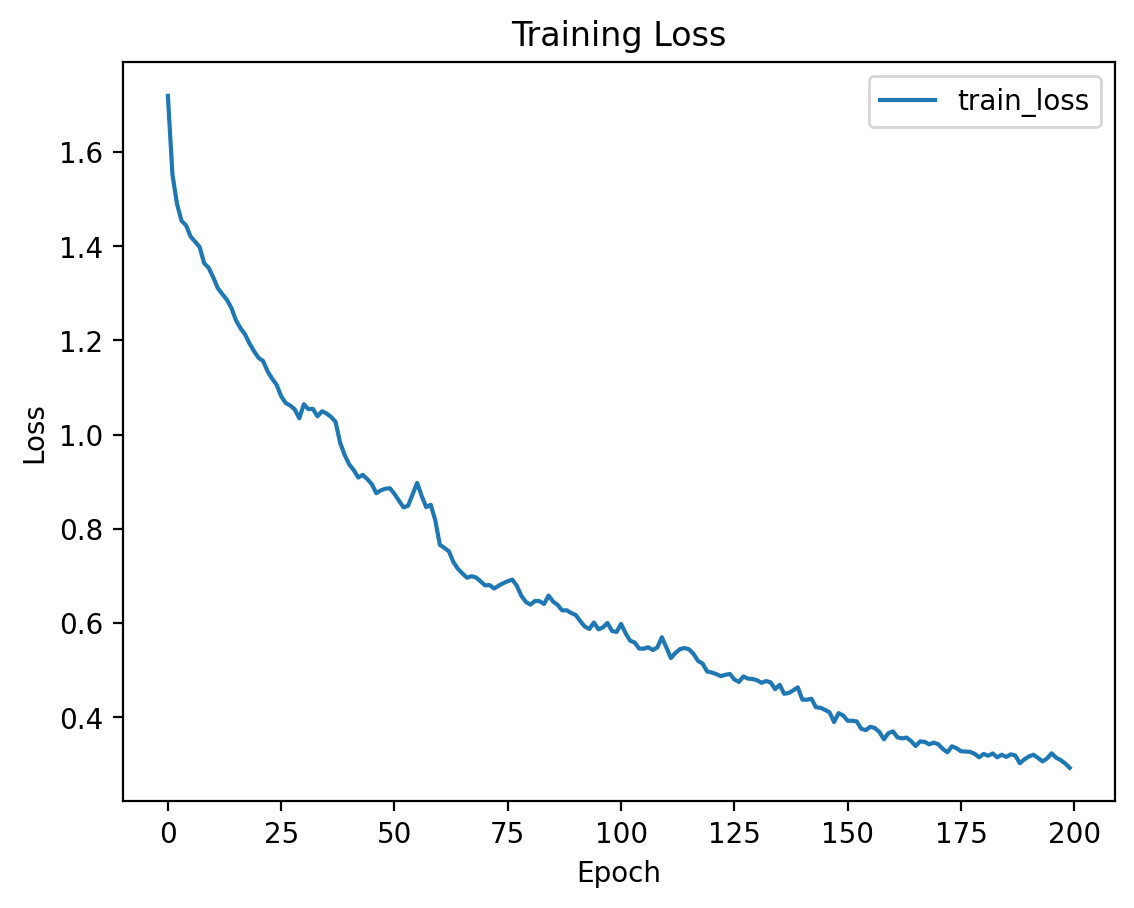

GPU Memory Allocated: 98.34 MB
GPU Memory Cached: 608.00 MB


In [55]:
if torch.cuda.is_available():
    print("CUDA está disponible. Usando GPU.")
else:
    print("CUDA no está disponible. Usando CPU.")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# Enviar el modelo al dispositivo
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

num_epochs = 200
batch_size = 256

train_loss_history = []

for epoch in range(num_epochs):
    model.train(True)
    running_loss = 0.0
    num_batches = 0

    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        # Limpiar los gradientes de la iteración anterior
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Cálculo de la pérdida
        loss = loss_function(outputs, labels)

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        # Acumular la pérdida
        running_loss += loss.item()
        num_batches += 1

    # Calcular el promedio de la pérdida para la época
    epoch_loss = running_loss / num_batches
    train_loss_history.append(epoch_loss)

    # Imprimir la pérdida promedio por época
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {epoch_loss:.4f}")

# Graficar la pérdida de entrenamiento
plt.plot(train_loss_history, label="train_loss") 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Comprobar el uso de memoria de la GPU
if torch.cuda.is_available():
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device) / 1024**2:.2f} MB")


### Generando la composición musical del modelo

La función genera una secuencia de notas musicales, basándose en una "semilla" aleatoria de entrada tomada del conjunto de datos de prueba (X_test), y va prediciendo nota a nota utilizando el modelo LSTM.

C:\Users\jcast\AppData\Local\Temp\ipykernel_11068\830694478.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  semilla = torch.tensor(semilla, dtype=torch.float32).clone().detach().to(device)


Executing command: "C:\Program Files\MuseScore 4\bin\MuseScore4.exe" -o "C:\Users\jcast\AppData\Local\Temp\music21\tmp9we3b_y2.png" "C:\Users\jcast\AppData\Local\Temp\music21\tmp9we3b_y2.musicxml"
Command stdout: 
Command stderr: 


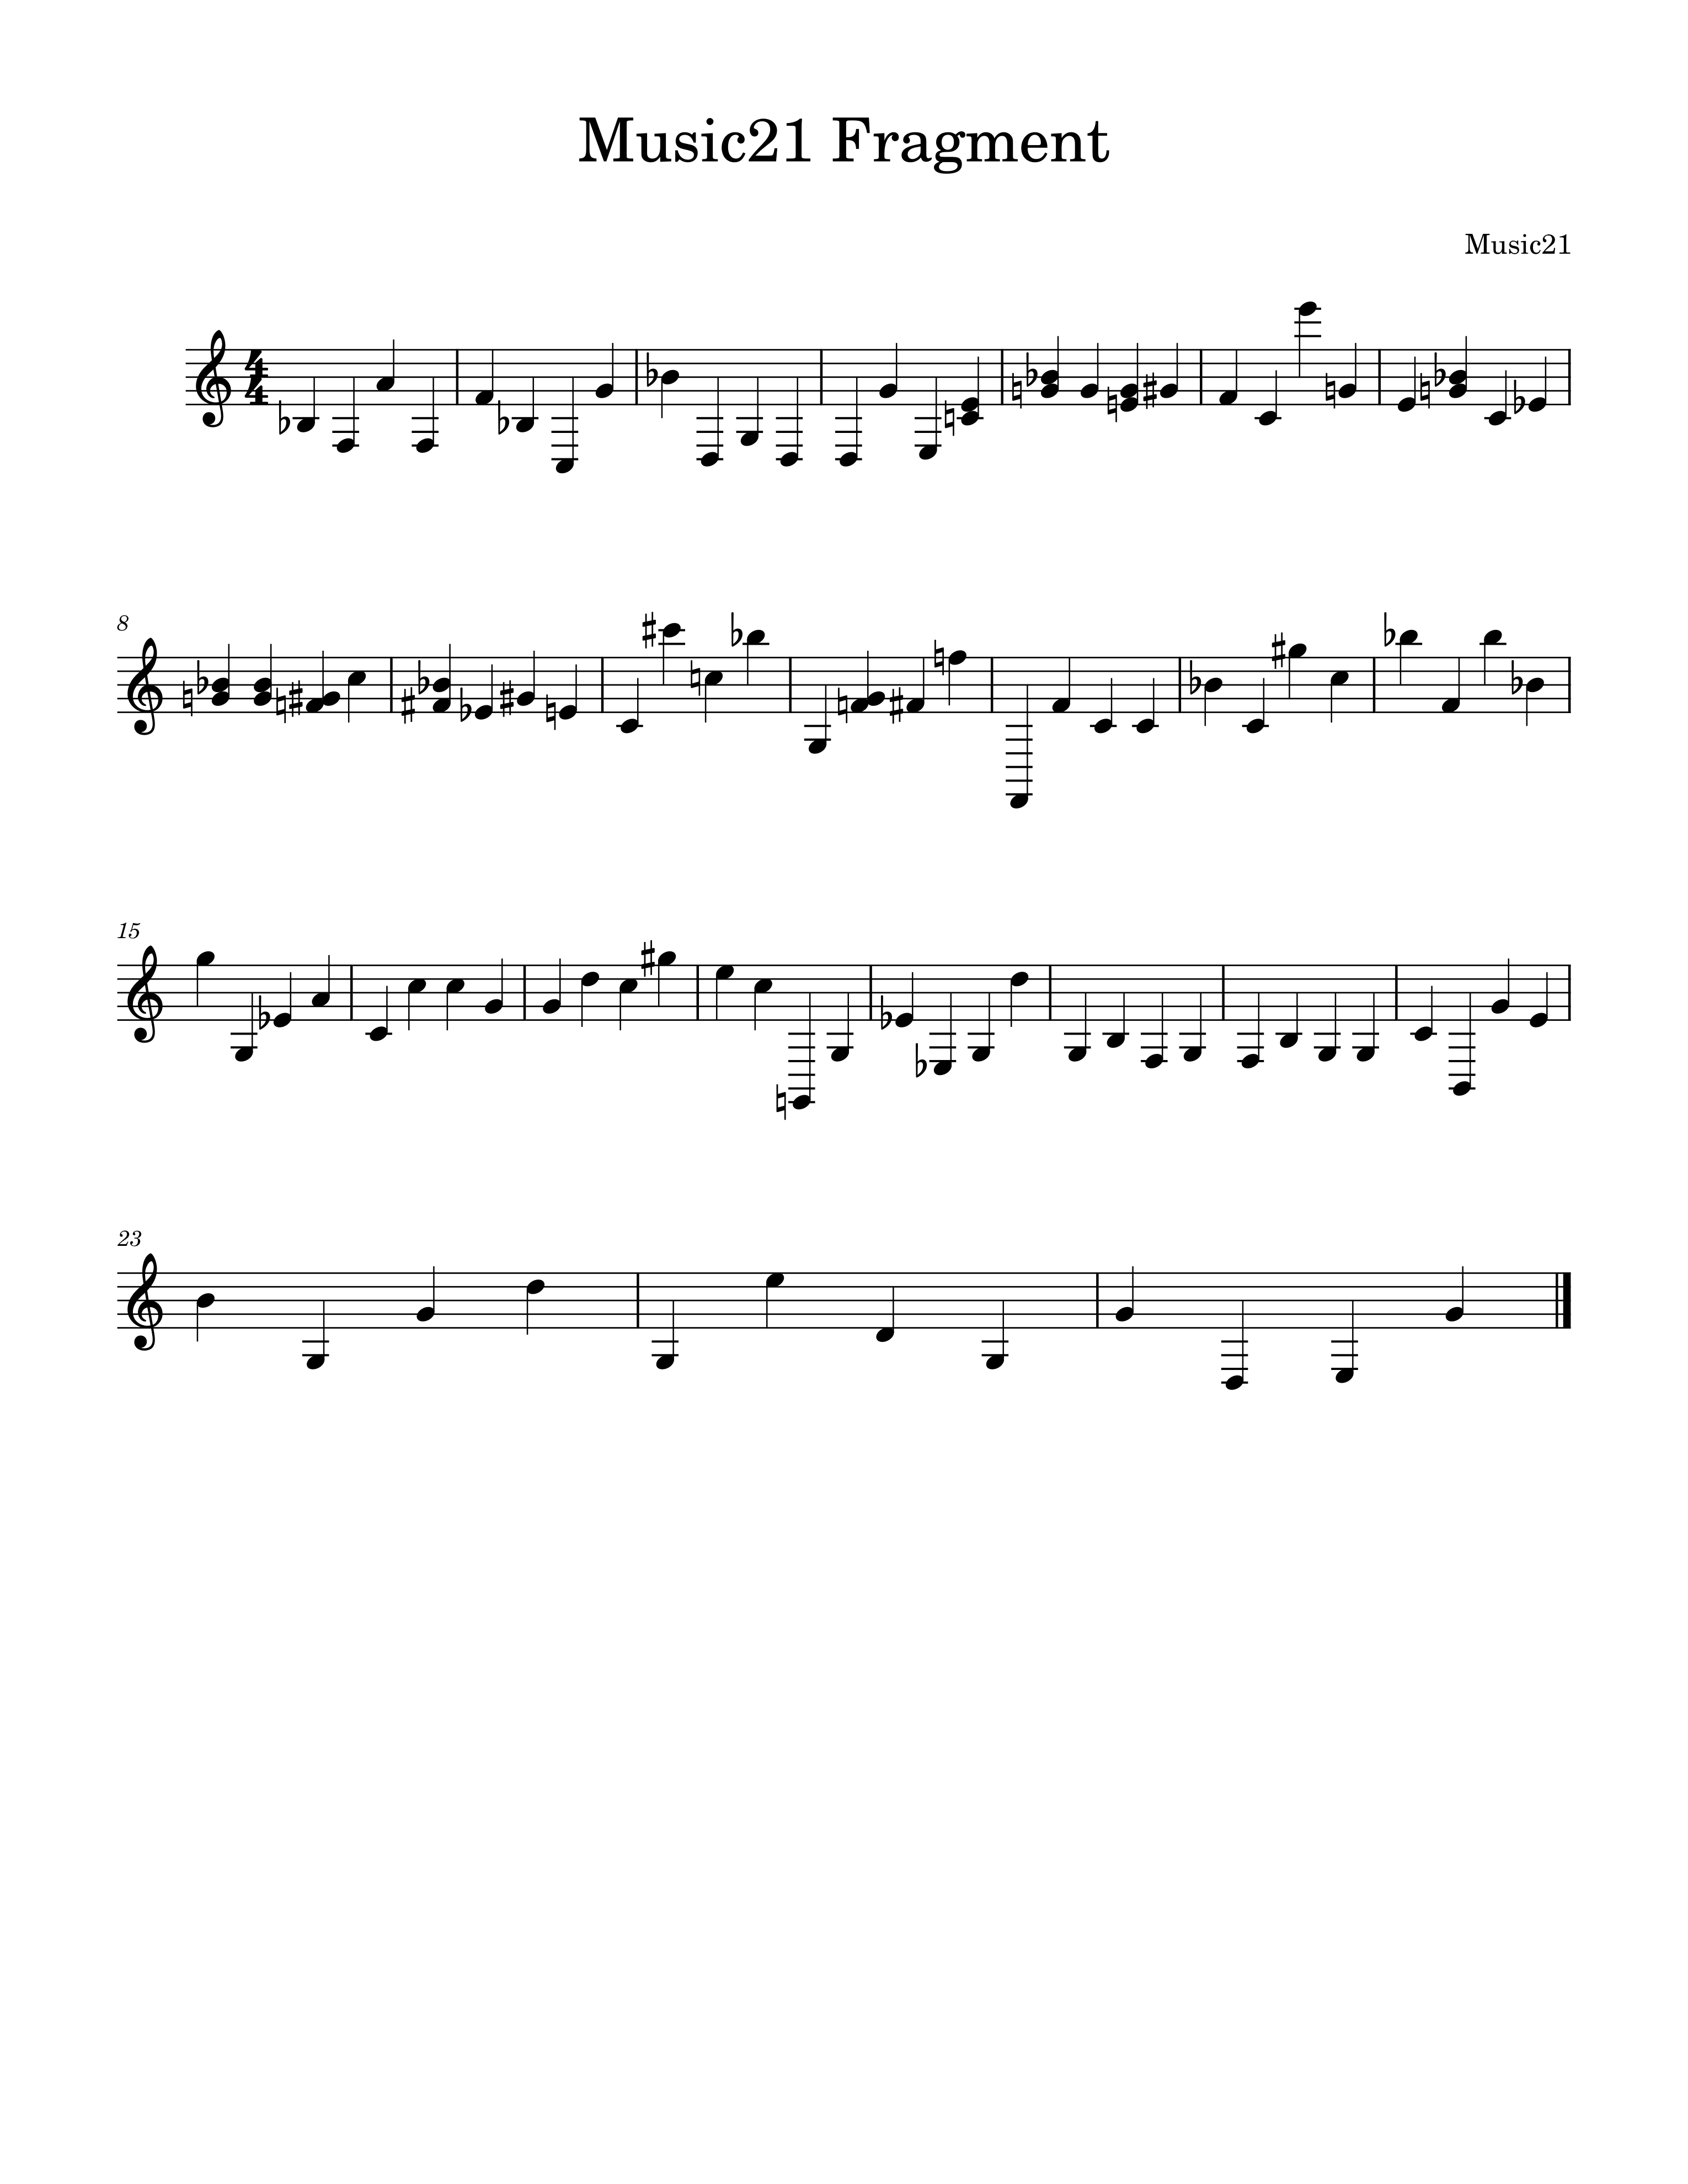

In [44]:
def generador_melodias(num_notas, model):
    # Seleccionamos una secuencia de prueba aleatoria como semilla
    semilla = X_test[np.random.randint(0, len(X_test) - 1)]
    Music = ""
    Notas_generadas = []

    # Convertimos semilla a tensor y lo movemos al dispositivo (CPU o GPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    semilla = torch.tensor(semilla, dtype=torch.float32).clone().detach().to(device)

    for i in range(num_notas):
        # Redimensionamos la semilla para que sea compatible con la entrada del modelo
        semilla = semilla.view(1, size, 1)

        # Hacemos la predicción con el modelo (movemos los datos a dispositivo)
        model = model.to(device)
        with torch.no_grad():
            prediccion = model(semilla).cpu().numpy()[0]

        # Seleccionamos el índice con la mayor probabilidad
        index = np.argmax(prediccion)



        # Normalizamos el índice para mantener el rango
        index_N = index / float(len_dic_notas_unicas)

        # Guardamos la nota generada
        Notas_generadas.append(index)

        # Convertimos los índices generados en notas usando el mapeo inverso
        Music = [mapeo_inverso[char] for char in Notas_generadas]

        # Actualizamos la semilla con la nueva nota
        semilla = torch.cat((semilla[0, 1:], torch.tensor([[index_N]], dtype=torch.float32).clone().detach().to(device)), dim=0)

    # Convertimos la lista de notas en una secuencia legible
    Melodia = join_to_print(Music)

    # Creamos un objeto stream de music21 para la melodía
    Melodia_midi = stream.Stream()
    for elemento in Melodia:
        Melodia_midi.append(elemento)

    return Music, Melodia_midi

# Ejemplo de uso
Notas_musicales, Melodias = generador_melodias(100, model)

# Mostrar la partitura de la melodía generada
mostrar_partitura(Melodias)

In [45]:
Melodias.show('midi')

## Guardando y Cargando los Modelos entrenados

Guardamos los parámetros (pesos y bias) de el modelo a el disco, 

In [34]:
import joblib

In [62]:
music_generator= {
    'modelo':model,
    'X_train':X_train,
    'y_train': y_train,
    'X_test': X_test,
    'y_test': y_test,
    'input_size': input_size,
    'hidden_size_1': hidden_size_1,
    'hidden_size_2': hidden_size_2,
    'weights':outputs
}

In [63]:
joblib.dump(music_generator,'music_generator.joblib')

['music_generator.joblib']

In [37]:
json = joblib.load('music_generator.joblib')
json.keys()
json['modelo']

# traer el modelo
""" modelo = json['modelo']
modelo """

LSTMModel(
  (lstm_1): LSTM(1, 512, batch_first=True, dropout=0.1)
  (lstm_2): LSTM(512, 256, batch_first=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=248, bias=True)
)